In [2]:
using ExpDataSets, Dates, CSV, FileIO, JLD2, Chain, DataFrames, DataFramesMeta, StatsBase, Measurements, Plots 
include("other_utils.jl")


┌ Info: Precompiling ExpDataSets [502e9419-551d-40e3-9007-99df92d05256]
└ @ Base loading.jl:1423
┌ Warning: Package ExpDataSets does not have PyCall in its dependencies:
│ - If you have ExpDataSets checked out for development and have
│   added PyCall as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ExpDataSets
└ Loading PyCall into ExpDataSets from project dependency, future warnings for ExpDataSets are suppressed.
  ** incremental compilation may be fatally broken for this module **



agent_ps_plot (generic function with 1 method)

In [ ]:
et =  load("Data/behavior_dataset.jld2", "event_time_series")

In [4]:
oi=@chain begin 
    @subset(et, :agent.=="Object", :behavior.=="Immobility")
    select(:lfp, :file, :start_time, :end_time)
    @transform(@byrow :duration = duration(:lfp) )
    minimum(_.duration)
end

2.7997227997227583

In [5]:
ps =  @chain et begin 
    @subset( (:end_time .- :start_time).≥ 1.0)
    transform(:lfp => ByRow.(x->normalize(x))=>:lfp)
    transform(:lfp => ByRow.(x->binps(compute_power_spectrum(x),60,120))=>:pspec)
    @select(:rat, :trial_type, :agent, :behavior, :region, :pspec)
end

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/leobreston/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


,rat,trial_type,agent,behavior,region,pspec
,String7?,String15?,String7?,String15?,String,PowerSp…
1,RRSD18,Habituation,Robot,Sniff,ca2,"PowerSpectrum([3.07128e-6, 1.6631e-5, 3.02731e-5, 2.81422e-6, 1.12312e-5, 3.60622e-6, 4.30226e-6, 3.95264e-6, 8.67344e-7, 7.88867e-7, 2.14606e-6, 1.89445e-6, 1.30196e-6, 7.67026e-7, 1.43792e-6, 1.00663e-6, 8.51716e-7, 5.37997e-7, 1.02781e-6, 5.07848e-7, 7.0554e-7, 6.52163e-7, 7.74849e-7, 1.83409e-7, 5.24784e-7, 2.20538e-7, 1.64672e-7, 1.52227e-7, 1.13682e-7, 1.55158e-7, 2.38773e-9, 6.69584e-8, 7.01712e-8, 1.04539e-7, 1.1842e-7, 7.29219e-8, 2.09575e-7, 3.54007e-8, 8.52459e-8, 7.92033e-8, 9.09024e-8, 6.89e-8, 4.30581e-8, 2.17966e-8, 1.78056e-8, 5.15617e-8, 4.3149e-8, 3.42673e-8, 3.35996e-8, 1.49291e-8, 3.99216e-8, 3.44612e-8, 5.46452e-8, 3.9132e-8, 3.97313e-8, 3.37083e-8, 3.23738e-8, 3.03509e-8, 5.87783e-8, 1.72232e-8], [1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 25.0, 27.0, 29.0, 31.0, 33.0, 35.0, 37.0, 39.0, 41.0, 43.0, 45.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 59.0, 61.0, 63.0, 65.0, 67.0, 69.0, 71.0, 73.0, 75.0, 77.0, 79.0, 81.0, 83.0, 85.0, 87.0, 89.0, 91.0, 93.0, 95.0, 97.0, 99.0, 101.0, 103.0, 105.0, 107.0, 109.0, 111.0, 113.0, 115.0, 117.0, 119.0])"
2,RRSD18,Habituation,Robot,Sniff,mob,"PowerSpectrum([5.76937e-7, 2.91192e-5, 2.86523e-5, 9.87942e-6, 4.08209e-6, 5.67138e-6, 1.59866e-6, 3.25844e-7, 7.81232e-7, 5.24171e-7, 8.40265e-7, 1.49545e-7, 3.22669e-7, 1.62734e-7, 1.81137e-7, 9.48898e-8, 1.67852e-7, 8.56861e-8, 1.36645e-7, 1.37303e-7, 9.33778e-8, 1.52551e-7, 1.56977e-7, 1.57508e-7, 6.38986e-8, 1.69247e-7, 3.05481e-7, 2.29685e-7, 3.28459e-7, 6.08432e-7, 4.26249e-8, 3.53989e-7, 2.7069e-7, 2.27843e-7, 2.43599e-7, 1.67809e-7, 2.0633e-7, 2.06878e-7, 3.04442e-7, 3.99136e-7, 5.18641e-7, 2.56478e-7, 5.90491e-7, 4.53011e-7, 3.44427e-7, 5.32484e-7, 4.24327e-7, 2.38018e-7, 2.61669e-7, 1.20617e-7, 2.89779e-7, 1.44608e-7, 9.28711e-8, 1.80089e-7, 1.37095e-7, 9.35582e-8, 2.08882e-7, 9.94891e-8, 9.93096e-8, 1.15114e-7], [1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 25.0, 27.0, 29.0, 31.0, 33.0, 35.0, 37.0, 39.0, 41.0, 43.0, 45.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 59.0, 61.0, 63.0, 65.0, 67.0, 69.0, 71.0, 73.0, 75.0, 77.0, 79.0, 81.0, 83.0, 85.0, 87.0, 89.0, 91.0, 93.0, 95.0, 97.0, 99.0, 101.0, 103.0, 105.0, 107.0, 109.0, 111.0, 113.0, 115.0, 117.0, 119.0])"
3,RRSD18,Habituation,Robot,Sniff,amyg,"PowerSpectrum([1.12679e-6, 2.99085e-5, 2.54006e-5, 5.13164e-6, 2.71074e-6, 2.97693e-6, 2.62494e-6, 2.57331e-6, 1.73094e-6, 1.39747e-6, 1.66669e-6, 9.434e-7, 1.56755e-6, 4.01384e-7, 6.3898e-7, 4.95707e-7, 4.73893e-7, 3.30798e-7, 4.44328e-7, 1.84121e-7, 4.34075e-7, 2.00276e-7, 6.17054e-7, 3.0307e-7, 4.54202e-7, 4.12314e-7, 5.37349e-7, 5.24015e-7, 8.6642e-7, 2.42368e-7, 2.89463e-8, 2.4932e-7, 1.91366e-7, 5.34186e-7, 4.61197e-7, 3.35911e-7, 6.26801e-7, 1.83613e-7, 3.09559e-7, 2.3172e-7, 1.79056e-7, 2.54542e-7, 3.32329e-7, 1.56137e-7, 2.82155e-7, 2.35436e-7, 3.07108e-7, 2.72614e-7, 1.18107e-7, 1.87497e-7, 1.27647e-7, 2.28446e-7, 7.28256e-8, 2.61554e-8, 1.13819e-7, 8.22419e-8, 1.65259e-7, 1.27976e-7, 2.29507e-7, 1.20566e-7], [1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 25.0, 27.0, 29.0, 31.0, 33.0, 35.0, 37.0, 39.0, 41.0, 43.0, 45.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 59.0, 61.0, 63.0, 65.0, 67.0, 69.0, 71.0, 73.0, 75.0, 77.0, 79.0, 81.0, 83.0, 85.0, 87.0, 89.0, 91.0, 93.0, 95.0, 97.0, 99.0, 101.0, 103.0, 105.0, 107.0, 109.0, 111.0, 113.0, 115.0, 117.0, 119.0])"
4,RRSD28,OF,missing,Rear,ca2,"PowerSpectrum([2.55985e-6, 5.37457e-5, 0.000153703, 4.56067e-6, 2.55485e-5, 3.54725e-6, 7.0199e-6, 2.96612e-6, 2.28554e-6, 6.5766e-6, 3.15979e-6, 4.83251e-6, 1.565e-6, 1.20812e-6, 3.63908e-8, 4.25799e-6, 9.66808e-7, 1.1891e-6, 2.23956e-7, 9.30962e-7, 8.23132e-7, 5.84708e-7, 5.3579e-7, 1.45586e-6, 3.08673e-7, 6.14183e-7, 7.56936e-7, 7.71745e-8, 1.07159e-7, 8.16468e-8, 4.65175e-8, 4.06413e-7, 5.73846e-7, 1.51727e-7, 9.87261e-8, 2.92952e-7, 1.2672e-7, 2.01279e

In [6]:
null_region_mps =  @chain ps begin 
    @subset(:behavior.=="null")
    transform(:pspec => ByRow.(x->values(x))=>:pspec)
    groupby([:region])
    @combine(:mps=[meanandstderr(:pspec)])
    transform(:mps=>ByRow.(x->Measurements.value.(x))=>:mpsvals, :mps=>ByRow.(x->Measurements.uncertainty.(x))=>:err)
    select(:region, :mpsvals=>:mps, :err)
end

,region,mps
,String,Array…
1,mob,"[3.36831e-6, 2.26293e-5, 1.91724e-5, 2.1313e-5, 2.21379e-5, 1.3764e-5, 5.00028e-6, 3.87559e-6, 3.13089e-6, 2.74588e-6, 1.87489e-6, 1.49723e-6, 8.41635e-7, 1.08616e-6, 7.37046e-7, 7.52496e-7, 6.57471e-7, 6.79267e-7, 5.3721e-7, 5.41362e-7, 6.40694e-7, 4.21981e-7, 4.67766e-7, 5.27359e-7, 6.46145e-7, 6.55057e-7, 6.81704e-7, 7.91539e-7, 1.06312e-6, 5.88544e-7, 7.31755e-8, 6.3843e-7, 8.85807e-7, 9.19112e-7, 8.37594e-7, 7.99879e-7, 7.7023e-7, 7.40114e-7, 6.4932e-7, 5.22485e-7, 6.81181e-7, 7.79352e-7, 6.51069e-7, 5.14479e-7, 5.95372e-7, 6.59854e-7, 5.37925e-7, 4.97829e-7, 5.31794e-7, 4.90232e-7, 5.27471e-7, 4.33091e-7, 3.70782e-7, 3.56976e-7, 3.163e-7, 3.43684e-7, 2.62102e-7, 2.45097e-7, 2.35375e-7, 2.41679e-7]"
2,ca2,"[3.9062e-6, 2.23986e-5, 1.70623e-5, 1.5526e-5, 4.03935e-5, 9.61344e-6, 3.59698e-6, 2.91877e-6, 3.75917e-6, 2.4544e-6, 2.30724e-6, 1.69458e-6, 1.48922e-6, 1.21362e-6, 1.3639e-6, 1.0063e-6, 9.97226e-7, 8.58381e-7, 7.75117e-7, 8.44183e-7, 6.36043e-7, 7.69739e-7, 7.72637e-7, 4.29522e-7, 5.45459e-7, 4.54663e-7, 4.23124e-7, 3.8681e-7, 3.83474e-7, 3.22293e-7, 3.6242e-8, 2.10072e-7, 2.69461e-7, 2.51277e-7, 2.69964e-7, 1.98181e-7, 2.16705e-7, 2.37787e-7, 2.0398e-7, 1.9648e-7, 1.82818e-7, 1.73693e-7, 1.39993e-7, 1.6374e-7, 1.35972e-7, 1.73236e-7, 1.26365e-7, 1.79907e-7, 1.65901e-7, 1.4353e-7, 1.51915e-7, 1.26088e-7, 1.25989e-7, 1.34407e-7, 1.33851e-7, 1.34122e-7, 1.31162e-7, 1.22215e-7, 1.35803e-7, 1.20953e-7]"
3,amyg,"[4.18874e-6, 2.26206e-5, 1.65787e-5, 9.68399e-6, 1.31839e-5, 6.32063e-6, 3.86754e-6, 3.44939e-6, 2.90775e-6, 2.80833e-6, 2.44544e-6, 1.87139e-6, 1.76956e-6, 1.51467e-6, 1.12983e-6, 1.15837e-6, 9.77713e-7, 9.59282e-7, 9.2815e-7, 7.57913e-7, 7.16786e-7, 8.28873e-7, 7.81115e-7, 6.88809e-7, 8.07416e-7, 7.36614e-7, 8.18035e-7, 7.87725e-7, 7.66015e-7, 5.8076e-7, 7.45818e-8, 5.21869e-7, 7.07837e-7, 6.84032e-7, 8.26472e-7, 6.53727e-7, 6.43432e-7, 5.53951e-7, 5.46003e-7, 4.91387e-7, 5.2984e-7, 5.41152e-7, 5.53688e-7, 4.76304e-7, 3.55693e-7, 4.59703e-7, 4.28525e-7, 5.2599e-7, 4.87174e-7, 4.18944e-7, 3.97158e-7, 3.93073e-7, 3.97246e-7, 3.81907e-7, 3.96886e-7, 3.58795e-7, 3.91694e-7, 3.13214e-7, 3.56041e-7, 2.7615e-7]"


In [7]:
behavior_agent_mps =  @chain ps begin 
    @subset(:behavior.!="null")
    transform(:pspec => ByRow.(x->values(x))=>:pspec)
    groupby([:behavior, :agent, :region])
    @combine(mps=[meanandstderr(:pspec)])
    transform(:mps=>ByRow.(x->Measurements.value.(x))=>:mpsvals, :mps=>ByRow.(x->Measurements.uncertainty.(x))=>:err)
    select(:behavior, :agent, :region, :mpsvals=>:mps, :err)
end

┌ Warning: Using an un-quoted Symbol on the LHS is deprecated. Write :mps = ... instead.
└ @ DataFramesMeta /Users/leobreston/.julia/packages/DataFramesMeta/yzaoq/src/parsing.jl:298


,behavior,agent,region,mps
,String15?,String7?,String,Array…
1,Sniff,Robot,ca2,"[4.81641e-6, 3.94802e-5, 1.92786e-5, 2.09715e-5, 4.76745e-5, 1.13627e-5, 3.7371e-6, 3.75391e-6, 4.18732e-6, 3.02379e-6, 2.86721e-6, 2.73357e-6, 2.21198e-6, 1.64178e-6, 1.54909e-6, 1.65617e-6, 1.37615e-6, 1.08661e-6, 1.1277e-6, 9.92227e-7, 8.88569e-7, 9.58686e-7, 8.91328e-7, 8.41464e-7, 7.75278e-7, 6.1152e-7, 5.61572e-7, 5.10074e-7, 6.31642e-7, 4.07228e-7, 5.46032e-8, 3.58811e-7, 4.34718e-7, 4.26953e-7, 3.10301e-7, 3.34279e-7, 3.16927e-7, 2.98533e-7, 2.62842e-7, 2.52062e-7, 3.20695e-7, 2.97157e-7, 2.31246e-7, 2.36249e-7, 2.79168e-7, 2.13592e-7, 2.60336e-7, 2.12976e-7, 2.01842e-7, 1.80545e-7, 1.94658e-7, 1.79529e-7, 1.94725e-7, 2.01584e-7, 2.4155e-7, 2.16433e-7, 1.85889e-7, 1.71736e-7, 1.86835e-7, 1.98438e-7]"
2,Sniff,Robot,mob,"[3.38577e-6, 4.05184e-5, 2.35015e-5, 3.07799e-5, 3.63769e-5, 1.40563e-5, 7.69171e-6, 7.10779e-6, 4.48781e-6, 3.84465e-6, 2.54514e-6, 1.93587e-6, 1.78483e-6, 1.37239e-6, 1.26551e-6, 8.39278e-7, 1.03429e-6, 8.40099e-7, 7.31228e-7, 6.53281e-7, 5.05144e-7, 7.11878e-7, 7.36654e-7, 7.85786e-7, 6.48759e-7, 6.96877e-7, 8.41598e-7, 9.50037e-7, 1.88643e-6, 1.08305e-6, 1.03794e-7, 8.47512e-7, 1.13719e-6, 9.46255e-7, 9.25629e-7, 9.45895e-7, 9.61624e-7, 8.85134e-7, 7.85149e-7, 8.62683e-7, 6.12627e-7, 6.83039e-7, 8.12366e-7, 7.34305e-7, 5.61592e-7, 7.16625e-7, 7.93582e-7, 6.60678e-7, 7.38615e-7, 6.66809e-7, 6.18856e-7, 7.28463e-7, 5.61699e-7, 4.36195e-7, 4.58618e-7, 5.00883e-7, 3.69649e-7, 3.89104e-7, 3.38604e-7, 3.76273e-7]"
3,Sniff,Robot,amyg,"[5.57509e-6, 4.82689e-5, 1.67492e-5, 1.25847e-5, 2.161e-5, 6.77114e-6, 4.72088e-6, 4.6273e-6, 3.56959e-6, 4.02541e-6, 3.13612e-6, 2.78229e-6, 2.37571e-6, 2.20114e-6, 2.13032e-6, 1.77018e-6, 1.73084e-6, 1.51888e-6, 9.8981e-7, 1.03552e-6, 1.06516e-6, 9.85313e-7, 1.03419e-6, 8.88798e-7, 8.76311e-7, 7.9451e-7, 9.74855e-7, 1.04763e-6, 1.01881e-6, 7.06357e-7, 1.12588e-7, 7.07959e-7, 9.38359e-7, 9.08105e-7, 7.30294e-7, 8.95094e-7, 8.07272e-7, 6.77417e-7, 7.61466e-7, 6.39261e-7, 7.09524e-7, 6.18513e-7, 6.82769e-7, 4.89403e-7, 6.61435e-7, 5.7213e-7, 6.16046e-7, 4.93789e-7, 5.60829e-7, 5.17705e-7, 5.17769e-7, 4.3627e-7, 4.5874e-7, 4.46642e-7, 5.0393e-7, 4.80065e-7, 3.68857e-7, 4.31553e-7, 4.25597e-7, 4.57661e-7]"
4,Rear,missing,ca2,"[3.34559e-6, 2.66488e-5, 1.68976e-5, 1.49134e-5, 3.92536e-5, 9.2804e-6, 3.97187e-6, 3.21646e-6, 3.74126e-6, 3.09537e-6, 2.51754e-6, 2.27649e-6, 1.72979e-6, 1.42264e-6, 1.24834e-6, 1.23931e-6, 8.53757e-7, 8.37741e-7, 8.42532e-7, 7.61724e-7, 7.10381e-7, 6.80832e-7, 6.64197e-7, 6.1537e-7, 5.40819e-7, 4.74667e-7, 4.11583e-7, 4.04413e-7, 4.28485e-7, 2.70747e-7, 3.03794e-8, 2.43515e-7, 2.98071e-7, 2.78608e-7, 2.62952e-7, 2.17719e-7, 2.15419e-7, 2.16663e-7, 1.75864e-7, 1.78776e-7, 1.66838e-7, 1.62561e-7, 1.65459e-7, 1.55679e-7, 1.52585e-7, 1.42333e-7, 1.51309e-7, 1.47392e-7, 1.27415e-7, 1.28878e-7, 1.28505e-7, 1.31292e-7, 1.26817e-7, 1.29704e-7, 1.2499e-7, 1.20358e-7, 1.37232e-7, 1.32026e-7, 1.28989e-7, 1.17011e-7]"
5,Rear,missing,amyg,"[4.25652e-6, 2.97393e-5, 1.54388e-5, 1.03498e-5, 1.29648e-5, 6.09911e-6, 3.76059e-6, 3.51869e-6, 3.34515e-6, 2.85109e-6, 2.44268e-6, 2.30071e-6, 1.81309e-6, 1.69831e-6, 1.39688e-6, 1.4008e-6, 1.05269e-6, 1.09204e-6, 1.02704e-6, 9.85094e-7, 9.31592e-7, 9.01851e-7, 9.65691e-7, 8.26598e-7, 7.92978e-7, 9.04469e-7, 8.89714e-7, 9.27939e-7, 9.47982e-7, 7.24642e-7, 9.03452e-8, 6.46265e-7, 8.48103e-7, 7.65133e-7, 7.77924e-7, 6.87774e-7, 7.14738e-7, 6.72311e-7, 6.53416e-7, 6.28946e-7, 6.2289e-7, 6.29711e-7, 5.60871e-7, 5.71112e-7, 5.49843e-7, 4.97436e-7, 4.76261e-7, 4.83478e-7, 4.2579e-7, 4.11904e-7, 3.76798e-7, 4.15034e-7, 3.77107e-7, 3.81841e-7, 3.6239e-7, 3.41001e-7, 3.82307e-7, 3.54438e-7, 3.36354e-7, 3.23114e-7]"
6,Rear,missing,mob,"[2.70663e-6, 2.47498e-5, 2.15065e-5, 2.62854e-5, 2.46215e-5, 1.23189e-5, 4.65721e-6, 4.3474e-6, 3.41872e-6, 2.33152e-6, 1.92011e-6, 1.49604e-6, 1.09076e-6, 9.68019e-7, 8.38415e-7, 8.51315e-7, 7.52157e-7, 6.37302e-7, 5.6644e-7, 6.0

In [8]:
@subset(behavior_agent_mps, :agent.=="Object", :behavior.=="Immobility", :region.=="amyg").mps

1-element Vector{Vector{Float64}}:
 [2.9190907538411685e-6, 1.8527499747890437e-5, 8.169065207259974e-6, 5.8678557885256995e-6, 6.031513166680483e-6, 2.5279197852867266e-6, 1.8324650522633257e-6, 1.299994726205715e-6, 1.416362838583721e-6, 1.4713935797488638e-6  …  1.1529652330907014e-7, 1.1499764215458339e-7, 1.1441613963383494e-7, 1.14034322073425e-7, 1.2498982551094333e-7, 1.1369479891828909e-7, 1.0398312399081499e-7, 1.0544183035638288e-7, 8.526780476701172e-8, 1.1063200213340428e-7]

In [9]:
freqs=2:2:120;  b="Immobility"; r="MOB"
s=@subset(behavior_agent_mps, :behavior.== b, :region.== lowercase(r))
# s=@orderby(s, :agent)
labels =reshape(s.agent,1,length(s.agent)) 
# labels =map(x->"Agent: "*x, labels)
specs = s.mps
errs = s.err

gr()
p=plot(
    freqs, 
    specs, 
    ribbon=errs, 
    fillalpha=.2, 
    label=labels, 
    xaxis=:log,
    yaxis=:log, 
    ylabel="Power Spectral Density", 
    xlabel="Frequency (Hz)", 
    title=b*"\n"*r,
    linewidth=2.5,
    grid=false,
    
)
ns=@subset(null_region_mps, :region.== lowercase(r))
plot!(p, freqs, ns.mps, ribbon= ns.err, fillcolor=:black, fillalpha=.15, linewidth=2,  xlim=(2,120), linestyle=:dash, linecolor=:black, label="Baseline", legendtitle="Agent")




LoadError: MethodError: no method matching +(::Float64, ::Vector{Float64})
For element-wise addition, use broadcasting with dot syntax: scalar .+ array
[0mClosest candidates are:
[0m  +(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at ~/.asdf/installs/julia/1.7.0/share/julia/base/operators.jl:655
[0m  +(::Union{Float16, Float32, Float64}, [91m::BigFloat[39m) at ~/.asdf/installs/julia/1.7.0/share/julia/base/mpfr.jl:406
[0m  +([91m::ChainRulesCore.Tangent{P}[39m, ::P) where P at ~/.julia/packages/ChainRulesCore/7ZiwT/src/tangent_arithmetic.jl:146
[0m  ...

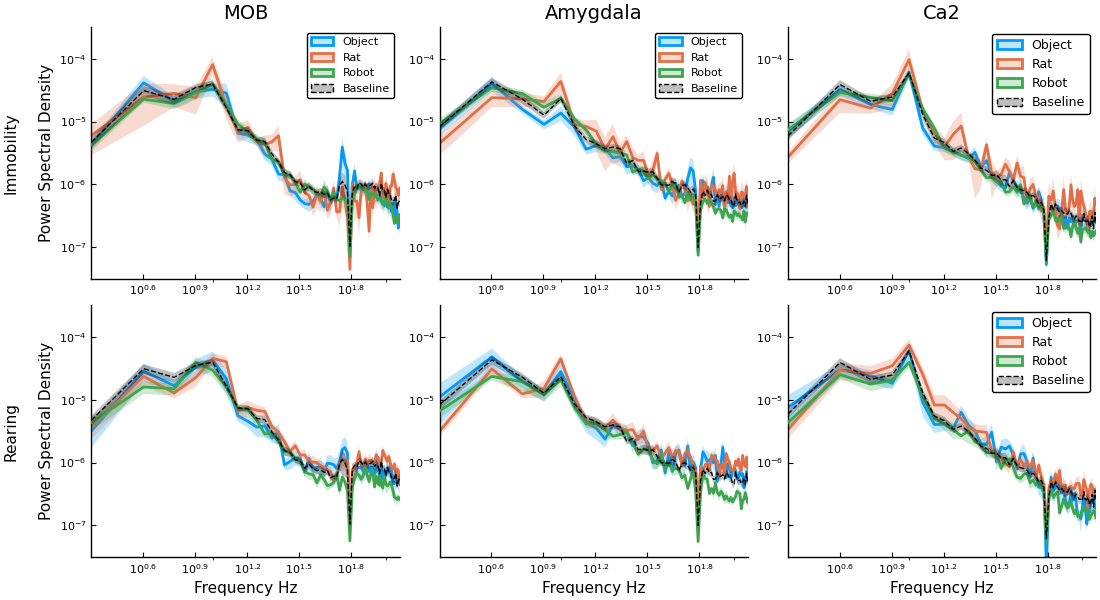

sys:1: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
sys:1: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
sys:1: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
sys:1: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


In [ ]:
import PyPlot
pyplot()
imm_mob=agent_ps_plot(behavior_agent_mps, null_region_mps, "Immobility", "MOB")
plot!(imm_mob, title="MOB", xlabel="", ylabel="Immobility\n\nPower Spectral Density")
imm_amyg=agent_ps_plot(behavior_agent_mps, null_region_mps, "Immobility", "Amyg")
plot!(imm_amyg, title="Amygdala", xlabel="")
imm_ca=agent_ps_plot(behavior_agent_mps, null_region_mps, "Immobility", "CA2")
plot!(imm_ca, title="Ca2", xlabel="", legendfontsize = 9, legend = :topright)
rear_mob=agent_ps_plot(behavior_agent_mps, null_region_mps, "Rearing", "MOB")
plot!(rear_mob, title="", xlabel="Frequency Hz", ylabel="Rearing\n\nPower Spectral Density")
rear_amyg=agent_ps_plot(behavior_agent_mps, null_region_mps, "Rearing", "Amyg")
plot!(rear_amyg, title="", xlabel="Frequency Hz")
rear_ca=agent_ps_plot(behavior_agent_mps, null_region_mps, "Rearing", "CA2")
plot!(rear_ca, title="", xlabel="Frequency Hz", legendfontsize = 9, legend = :topright)

p=plot(imm_mob, imm_amyg, imm_ca, rear_mob, rear_amyg, rear_ca)
plot!(p, grid=false, size = (1100, 600))
plot!(p, yticks=[10.0^x for x in -7:1:-4], ylim=(10.0^-7.5, 10.0^-3.5), xlim=(2,120))
# plot!(p, linestyle=[:solid :solid :solid :dash], linewidth=[3 3 3 3])

# PyPlot.suptitle("Region")
# PyPlot.savefig("suptile_test.png")
